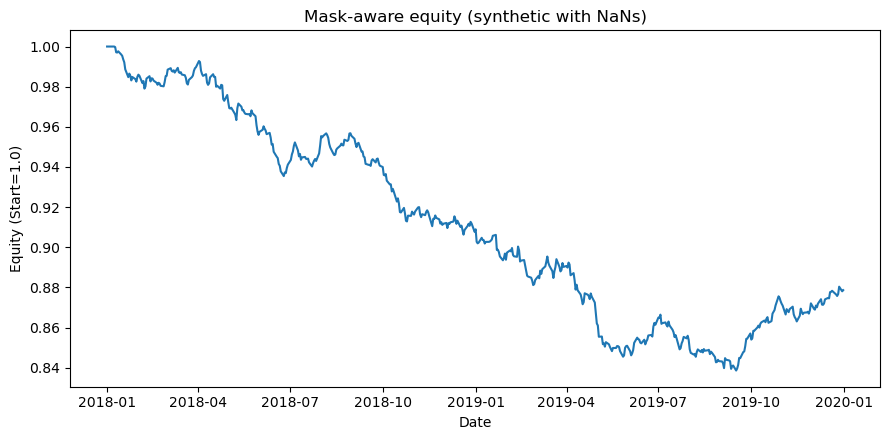

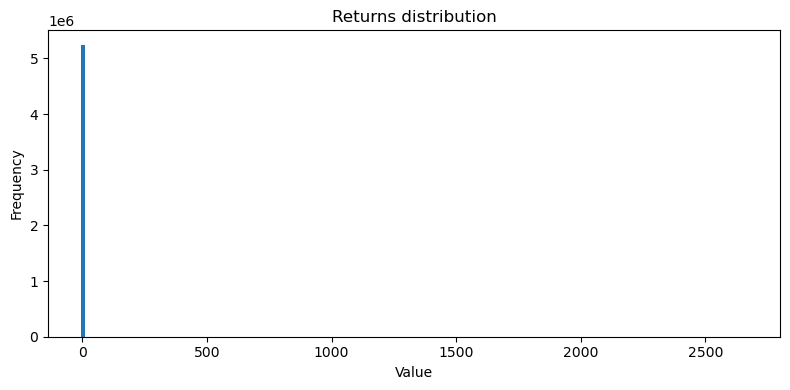

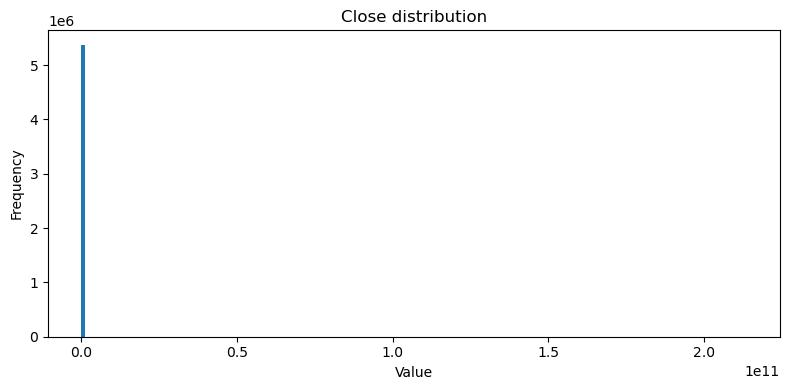

C:\Users\g3055\AppData\Local\Temp\ipykernel_38076\216571597.py:86: RuntimeWarning: invalid value encountered in log
  _plot_hist(np.log(close.to_numpy().astype(float)).ravel(), "Log(Close) distribution", bins=200, filename=f"{outdir}/hist_log_close.png")


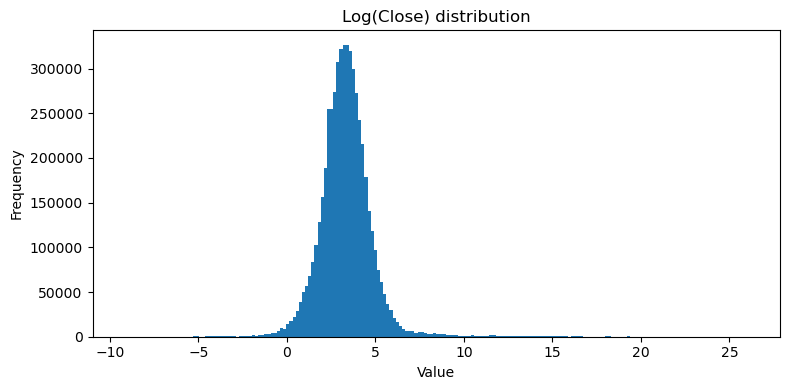

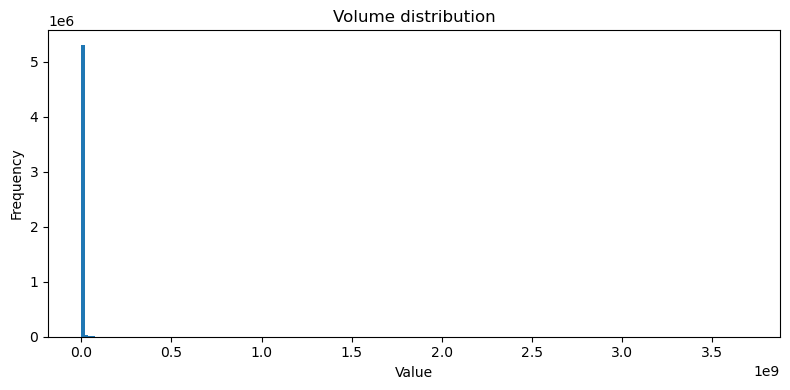

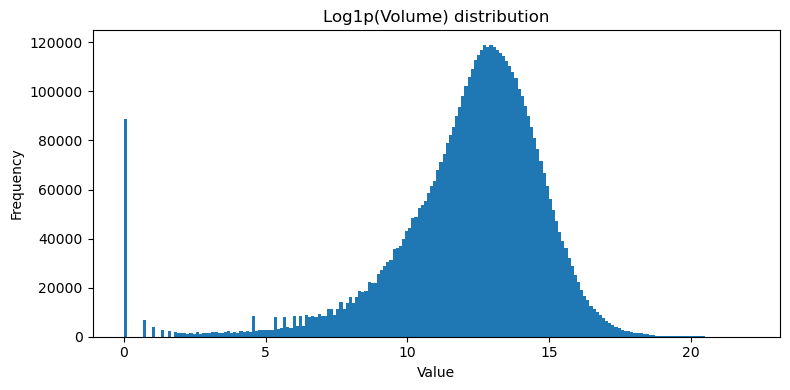

           count  missing_pct        min        1%           5%           25%  \
name                                                                            
returns  7372197    28.892459  -3.758620 -0.097927    -0.047847     -0.012431   
close    7372197    27.113966 -37.709606  0.890000     3.180000     12.112698   
volume   7372197    27.113966   0.000000  0.000000  1030.000000  59200.000000   

                   50%           75%           95%           99%  \
name                                                               
returns       0.000000  1.264287e-02  4.829209e-02  1.105958e-01   
close        26.712832  5.845000e+01  2.348000e+02  4.500000e+03   
volume   295500.000000  1.077900e+06  5.947203e+06  2.064960e+07   

                  max          mean           std         skew      kurtosis  \
name                                                                           
returns  2.665667e+03  2.160561e-03  1.450863e+00  1419.398938  2.334878e+06   
close    2.13

In [1]:
%run function_sets.ipynb
from alpha_maco_safe import alpha_maco_plus, neutralize_by_group, vol_target_weights
import warnings
warnings.filterwarnings("ignore")

turnover:0.3095229054211536
{'ann_sharpe': 2.109847312242608, 'cagr': 0.25408956426942764, 'tot_return': 5.370699229895816, 'ann_vol': 0.11021396910074788, 'max_drawdown': -0.16862732652950096}


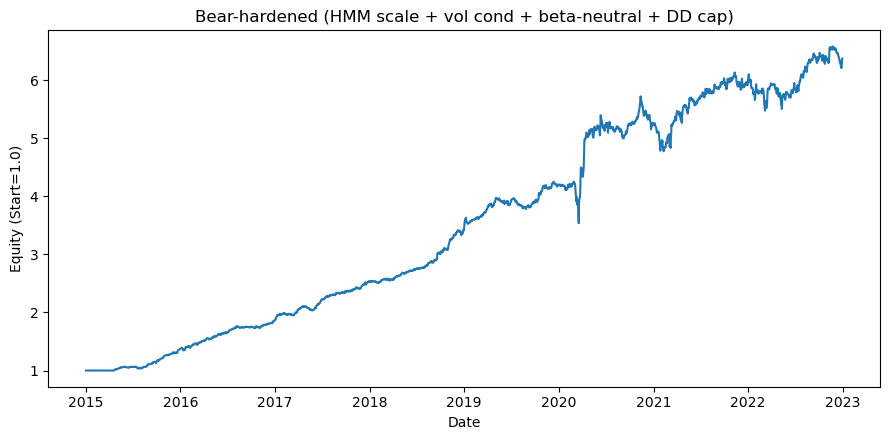

In [2]:
from alpha_hmm_v2 import hmm_overlay_scale            # non-inverting HMM (scale 0..1)
from risk_overlays import scale_by_market_vol, neutralize_to_market_beta, dd_exposure_scale
from alpha_maco_plus_gpu import alpha_ema_crossover_gpu   # your existing robust EMA alpha

# Base alpha (you choose; no default inside the HMM)
base_kwargs = dict(
    close=close, volume=volume,
    fast_span=5, slow_span=10, atr_span=36,use_global_mad_winsor=True, mad_k = 2,
    threshold_q=0.95, top_frac=0.05, min_keep=180,
    stale_span=5, stale_std_bp=1.0,
    hard_cap_abs_return=0.80,
    smooth_span=2
)
alpha_base = alpha_ema_crossover_gpu(**base_kwargs)[0]

alpha_regime, diag = hmm_overlay_scale(
    close=close,
    base_alpha_fn=lambda **kw: alpha_base,  # reuse precomputed alpha
    base_alpha_kwargs={},
    p_lo=0.45, p_hi=0.60, smooth_span=3
)

# 3) Volatility conditioner (downscale when market vol spikes)
alpha_vol = scale_by_market_vol(alpha_regime, close, lookback=20, gamma=0.25, s_min=0.4)

# 4) Weights (add market-beta neutralization)
tradable = build_tradable_mask(close, volume, 1.0, 1.0)
weights0 = make_weights(alpha_vol, gross_exposure=1.0, cap_per_name=0.01,
                        neutralize=True, method="zscore", mask=tradable, min_names=50)
weights_beta_neut = neutralize_to_market_beta(weights0, close, lookback=60)

# 5) Vol targeting + drawdown scaler (lagged)
rets = close.pct_change(fill_method=None)
# weights_vt = vol_target_weights(weights_beta_neut, rets, target_ann_vol=0.10, lookback=60, max_leverage=3.0)

bt = backtest_long_short(weights0, rets, cost_bps=2)
dd_scale = dd_exposure_scale(bt["ret_net"].shift(1).fillna(0.0), window=252, dd_cut=-0.08, floor=0.4, halflife=20)
weights_final = weights0.mul(dd_scale, axis=0)

# 6) Re-run backtest
bt2 = backtest_long_short(weights_final, rets, cost_bps=2)
print(f"turnover:{float(bt['two_way_turnover'].mean())}")
print(performance_stats(bt2["ret_net"]))
plot_equity_curve(bt2["ret_net"], title="Bear-hardened (HMM scale + vol cond + beta-neutral + DD cap)")

turnover:0.12222578302469853
{'ann_sharpe': 1.7406460920881588, 'cagr': 0.06848437023293963, 'tot_return': 0.7190264673403548, 'ann_vol': 0.03848566403805482, 'max_drawdown': -0.07903029875265177}


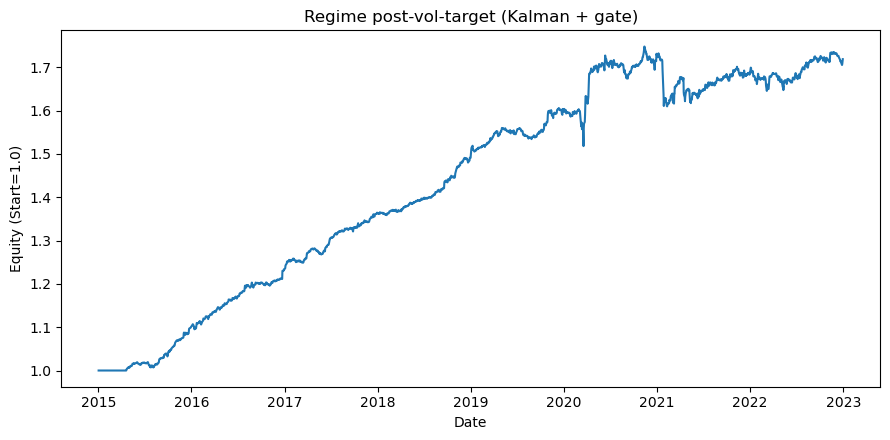

In [3]:
from kalman_overlays import  build_regime_scale, apply_scale_to_weights

# 1) Base alpha → weights → vol target (unchanged)
alpha = alpha_vol
tradable = build_tradable_mask(close, volume, 1.0, 1.0)
w0 = make_weights(alpha, gross_exposure=1.0, cap_per_name=0.005,
                  neutralize=True, method="zscore", mask=tradable, min_names=50)
rets = close.pct_change(fill_method=None)
# w_vt = vol_target_weights(w0, rets, target_ann_vol=0.10, lookback=60, max_leverage=3.0)

# 2) Regime scale (dynamic thresholds + Kalman + innovation gate)
s, diag = build_regime_scale(
    close, mode="dynamic", roll=252, q_lo=0.40, q_hi=0.60,
    kf_q=5e-5, kf_r=5e-4, z_gate=2.5, floor=0.3
)

# 3) Apply scale *after* vol targeting so it’s not undone
w_final = apply_scale_to_weights(w0, s)

# 4) Backtest
bt = backtest_long_short(w_final, rets, cost_bps=2)
print(f"turnover:{float(bt['two_way_turnover'].mean())}")

print(performance_stats(bt["ret_net"]))
plot_equity_curve(bt["ret_net"], title="Regime post-vol-target (Kalman + gate)")



[1/24] {'fast_span': 4, 'slow_span': 9, 'atr_span': 30, 'threshold_q': 0.9, 'mad_k': 2.0, 'top_frac': 0.1, 'min_keep': 180, 'stale_span': 5, 'stale_std_bp': 1.0, 'hard_cap_abs_return': 0.8, 'smooth_span': 2, 'device': 'cuda'}
[2/24] {'fast_span': 4, 'slow_span': 9, 'atr_span': 30, 'threshold_q': 0.9, 'mad_k': 2.0, 'top_frac': 0.15, 'min_keep': 180, 'stale_span': 5, 'stale_std_bp': 1.0, 'hard_cap_abs_return': 0.8, 'smooth_span': 2, 'device': 'cuda'}
[3/24] {'fast_span': 4, 'slow_span': 9, 'atr_span': 30, 'threshold_q': 0.9, 'mad_k': 2.0, 'top_frac': 0.05, 'min_keep': 180, 'stale_span': 5, 'stale_std_bp': 1.0, 'hard_cap_abs_return': 0.8, 'smooth_span': 2, 'device': 'cuda'}
[4/24] {'fast_span': 4, 'slow_span': 9, 'atr_span': 30, 'threshold_q': 0.9, 'mad_k': 1.8, 'top_frac': 0.1, 'min_keep': 180, 'stale_span': 5, 'stale_std_bp': 1.0, 'hard_cap_abs_return': 0.8, 'smooth_span': 2, 'device': 'cuda'}
[5/24] {'fast_span': 4, 'slow_span': 9, 'atr_span': 30, 'threshold_q': 0.9, 'mad_k': 1.8, 'top

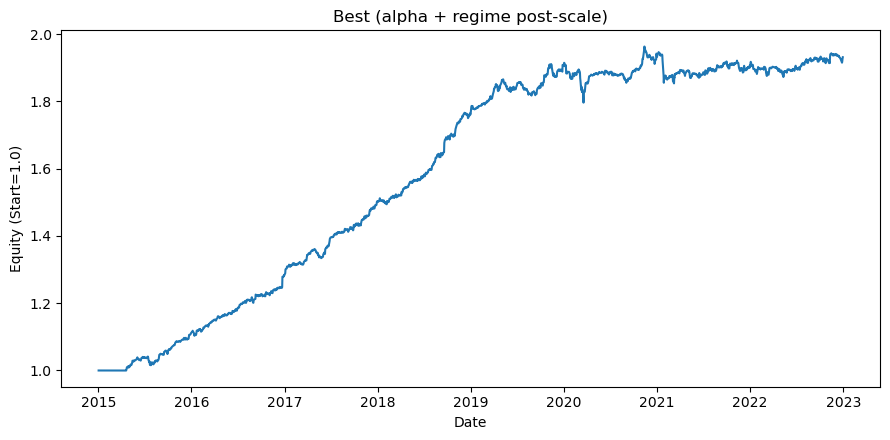

In [4]:
from grid_search_with_regime import grid_search_with_post_weights
from regime_post_scale import regime_post_scale
from quality_kinked import make_kinked_quality_fn
from alpha_maco_plus_gpu import alpha_ema_crossover_gpu as alpha_fn

# 1) Alpha param grid (no defaults hidden)
alpha_grid  = {
    "fast_span": [4],
    "slow_span": [9],
    "atr_span":  [30, 36], 
    "threshold_q": [0.90,0.95],
    'mad_k' : [2.0,1.8],
    "top_frac":   [0.1,0.15,0.05],
    "min_keep":   [180],
    "stale_span": [5],
    "stale_std_bp": [1.0],
    "hard_cap_abs_return": [0.8],
    "smooth_span": [2],
    "device": ["cuda"],             # for GPU alpha; drop for CPU alpha
}

# 2) Regime post-scaling grid (HMM + Kalman + innovation gate)
regime_grid = {
    "mode": ["dynamic"],                 # or "fixed"
    "roll": [252, 126],
    "q_lo": [0.35, 0.40], "q_hi": [0.60, 0.65],
    "kf_q": [5e-5, 1e-4], "kf_r": [5e-4, 1e-3],
    "z_gate": [2.0, 2.5], "floor": [0.3, 0.4],
}

# 3) Kinked quality function (tune as you like)
cfg = {
    "sharpe":     {"range": (1.5, 1.8), "m_below": -8.0, "m_in": 1.5, "m_above": 0.2},
    "turnover":   {"range": (0.25, 3), "higher_is_better": False, "m_below": -8.0, "m_in": 1.5, "m_above": 0.2},
    "max_weight": {"range": (0.05, 0.0), "higher_is_better": False, "m_below": -8.0, "m_in": 1.5, "m_above": 0.2},
    "tot_return": {"range": (2, 2.5), "m_below": -8.0, "m_in": 1.5, "m_above": 0.2},
}
quality_fn = make_kinked_quality_fn(cfg)

# 4) Fixed kwargs & plumbing
alpha_static = dict(close=close, volume=volume)
mw_kwargs = dict(gross_exposure=1.0, cap_per_name=0.01, neutralize=True,
                 method="zscore", mask=build_tradable_mask(close, volume, 1.0, 1.0), min_names=50)
bt_kwargs = dict(cost_bps=2)
vt_kwargs = dict(target_ann_vol=0.10, lookback=60, max_leverage=3.0)

# 5) Run the joint grid
results_df, best = grid_search_with_post_weights(
    alpha_fn=alpha_fn,
    alpha_grid=alpha_grid,
    regime_post_grid=regime_grid,
    close=close, volume=volume,
    make_weights_fn=make_weights, make_weights_kwargs=mw_kwargs,
    backtest_fn=backtest_long_short, backtest_kwargs=bt_kwargs,
    vol_target_fn=vol_target_weights, vol_target_kwargs=vt_kwargs,
    post_weights_fn=regime_post_scale, post_weights_base_kwargs=dict(close=close),
    returns=close.pct_change(fill_method=None),
    quality_fn=quality_fn,
    alpha_static_kwargs=alpha_static,
    progress=True,
    save_csv="./grid_results_regime.csv",
    return_artifacts=True
)

print("Best alpha params:", best["alpha_params"])
print("Best regime params:", best["regime_params"])
print("Best metrics:", best["metrics"])
plot_equity_curve(best["ret_net"], title="Best (alpha + regime post-scale)")
